In [3]:
! pip install diffprivlib # IBM library for differential privacy 

     |████████████████████████████████| 70 kB 1.5 MB/s eta 0:00:011
  Created wheel for diffprivlib: filename=diffprivlib-0.3.0-py3-none-any.whl size=138997 sha256=4cec290069e8a1d0a3817ff1fe390dda4e11d6ae9117c72dfc510e75a1917cbb
  Stored in directory: /home/ec2-user/.cache/pip/wheels/4f/58/be/155d9ca6a847207b8cf672bc97b5420f35da51a797cc3a3c5d
Successfully built diffprivlib
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
from diffprivlib.models import GaussianNB
from sklearn.metrics import confusion_matrix, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 900, 'display.max_rows', None, 'display.max_columns', None)
%matplotlib inline

In [5]:
df = pd.read_csv('lpetrocelli-lendingclub-loan-data-2017-q-1/LoanStats_2017Q1 2.csv',skiprows = 1)
df.shape

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,112) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(96781, 122)

In [6]:
df_loan = df[:-2]
df_loan.tail(2)
df['int_rate'] = df['int_rate'].str.replace('%','')

df['int_rate'] = pd.to_numeric(df['int_rate'],errors='coerce')

In [7]:
# Categorize employment length
def emp_to_num(term):
    if pd.isna(term):
        return None
    elif term[2]=='+':
        return 10
    elif term[0]=='<':
        return 0
    else:
        return int(term[0])

df['emp_length_num'] = df['emp_length'].apply(emp_to_num)

In [8]:
#Feature engineer - basically lender credit status
df.loc[:, 'flag'] = np.where((df.purpose == 'debt_consolidation') | (df.purpose == 'credit_card'),1.0, -1.0)
df['install_loan_ratio'] = (df['installment'] / df['loan_amnt']) * 100
df['long_emp'] = df['emp_length'].apply(lambda x: 1*(x=='10+ years'))
df['short_emp'] = df['emp_length'].apply(lambda x: 1*(x=='1 year' or x=='< 1 year'))

In [9]:
#Predict for good and bad - map loan status into 0 and 1
df['target']=df['loan_status'].map({'Current': 1,'Issued': 1, 'Fully Paid': 1, 'In Grace Period': 0, 'Late (31-120 days)':0, 'Late (16-30 days)':0}) 

In [10]:
#tranform annual income to log
df['annual_inc_log'] = df['annual_inc'].apply(np.log)


In [11]:
columns = ['loan_amnt', 'term', 'int_rate','flag','install_loan_ratio',
       'installment', 'grade', 'emp_length',
       'home_ownership', 'annual_inc_log', 'verification_status',
       'target', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc']
df = df[columns]

df.dropna(inplace=True)

In [12]:
df['grade']=df['grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})

In [13]:
#Copy dataframe
df_dummies = pd.get_dummies(df) 

drop_columns = df_dummies.columns[(df_dummies.mean()<0.01)]
df_dummies.drop(drop_columns, axis=1, inplace=True)

df_dummies['verification_status_Verified_sum'] = df_dummies['verification_status_Source Verified']+df_dummies['verification_status_Verified']
df_dummies.drop(['verification_status_Source Verified', 'verification_status_Verified'], axis=1, inplace=True)


df_dummies = df_dummies.rename(columns={'emp_length_10+ years':'emp_length_10 years','emp_length_< 1 year':'emp_length_less 1 year'})

In [19]:
#df_dummies = df_dummies.sample(frac=0.1)
#df_dummies.shape

In [14]:
# After cleaning, prepare training data
X = df_dummies.drop('target', axis=1)
y = df_dummies['target']
X.shape

(89940, 67)

In [15]:
#Drop zip code of states
drop_list1 = ['addr_state_AL',
       'addr_state_AZ', 'addr_state_CA', 'addr_state_CO', 'addr_state_CT',
       'addr_state_FL', 'addr_state_GA', 'addr_state_IL', 'addr_state_IN',
       'addr_state_LA', 'addr_state_MA', 'addr_state_MD', 'addr_state_MI',
       'addr_state_MN', 'addr_state_MO', 'addr_state_NC', 'addr_state_NJ',
       'addr_state_NV', 'addr_state_NY', 'addr_state_OH', 'addr_state_OR',
       'addr_state_PA', 'addr_state_SC', 'addr_state_TN', 'addr_state_TX',
       'addr_state_VA', 'addr_state_WA', 'addr_state_WI']

X.drop(drop_list1,axis=1,inplace=True)

In [16]:
# Build train and test set > 80:20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify = y,random_state=0) #0 6 = 0.698

In [17]:
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/naive_bayes.py:102: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  "privacy leakage, specify bounds for each dimension.", PrivacyLeakWarning)


GaussianNB(accountant=BudgetAccountant(spent_budget=[(1.0, 0)]),
           bounds=(array([1000.    ,    5.32  ,   -1.    ,    1.9333,   30.12  ,    1.    ,
         -1.    ,    0.    ,    0.    ,    1.    ,    0.    ,    0.    ,
          2.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
          0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
          0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
          0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
          0.    ,    0.    ,    0.    ]),
                   array([4.00000000e+04, 3.09900000e+01, 1.00000000e+00, 4.29980583e+00,
       1.71542000e+03, 7.00000000e+00, 9.99900000e+03, 2.10000000e+01,
       5.00000000e+...
       1.44000000e+02, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 

In [18]:
y_pred = nb_clf.predict(X_test)
y_pred[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [20]:
print("Test accuracy: %f" % nb_clf.score(X_test, y_test))

Test accuracy: 0.992773


In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
epsilons = np.logspace(-2, 2, 50)
#bounds = ([4.3, 2.0, 1.1, 0.1], [7.9, 4.4, 6.9, 2.5])
accuracy = list()

for epsilon in epsilons:
    clf = GaussianNB(epsilon=epsilon)
    clf.fit(X_train, y_train)
    
    accuracy.append(clf.score(X_test, y_test))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/naive_bayes.py:102: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  "privacy leakage, specify bounds for each dimension.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/naive_bayes.py:102: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  "privacy leakage, specify bounds for each dimension.", PrivacyLeakWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/diffprivlib/models/naive_bayes.py:102: PrivacyLeakWarning: Bounds have not been 

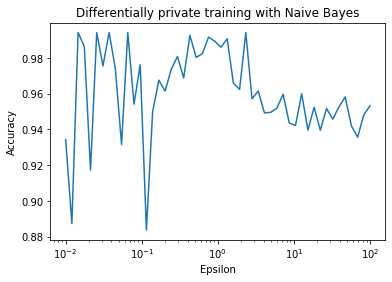

In [23]:
# Accuracy depend on the epsilon values
plt.semilogx(epsilons, accuracy)
plt.title("Differentially private training with Naive Bayes")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()